<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-US-state-geometries,-rivers,-lakes" data-toc-modified-id="Load-US-state-geometries,-rivers,-lakes-1">Load US state geometries, rivers, lakes</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#project-dataframes" data-toc-modified-id="project-dataframes-1.0.1">project dataframes</a></span></li></ul></li></ul></li><li><span><a href="#Download-drought-monitor-datasets" data-toc-modified-id="Download-drought-monitor-datasets-2">Download drought monitor datasets</a></span></li><li><span><a href="#Exploratory-analysis" data-toc-modified-id="Exploratory-analysis-3">Exploratory analysis</a></span><ul class="toc-item"><li><span><a href="#test-latest-data" data-toc-modified-id="test-latest-data-3.1">test latest data</a></span></li><li><span><a href="#test-historic-data" data-toc-modified-id="test-historic-data-3.2">test historic data</a></span></li></ul></li><li><span><a href="#Production-level-run" data-toc-modified-id="Production-level-run-4">Production-level run</a></span></li></ul></div>

Drought data is downloaded directly from https://droughtmonitor.unl.edu/data/shapefiles_m/. See https://droughtmonitor.unl.edu/Data/GISData.aspx for more details. There is weekly data from 2000 to present.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from shapely.geometry import Point, Polygon, box
import pandas as pd
import geopandas as gpd

from __future__ import division, print_function

In [2]:
# python 2/3 urllib fixer
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve
import zipfile
import requests
try:
    from bs4 import BeautifulSoup
except:
    from BeautifulSoup4 import BeautifulSoup

In [3]:
# EPSG codes of projections
proj_crs_latlon = 4326 # no projection, lat-lon
proj_crs_US = 2163 # Albers equal area projection centered on continental US

In [4]:
def shapefile_check_or_download(URL, path = 'input'):
    """
    Given URL of zipped shapefile, check if shapefile/directory already exists in given path.
    If not, downloads and unzips it there.
    Returns path to shapefile.
    """
    basename = URL.split('/')[-1].split('.zip')[0]
    try:
        name = [f for f in os.listdir(os.path.join(path, basename)) if f.endswith('.shp')]
    except:
        if not os.path.isfile(os.path.join(path,basename+'.zip')):
            urlretrieve(URL, os.path.join(path,basename+'.zip'))
        with zipfile.ZipFile(os.path.join(path, basename+'.zip'),"r") as zip_ref:
            zip_ref.extractall(os.path.join(path,basename))
        name = [f for f in os.listdir(os.path.join(path, basename)) if f.endswith('.shp')]

    if len(name)==1: 
        name=name[0]
    else: 
        print('Error: more than one .shp file in the directory --  {}'.format(path))

    return os.path.join(path, basename, name)

In [5]:
# EPSG codes of projections
proj_crs_latlon = 4326 # no projection, lat-lon
proj_crs_US = 2163 # Albers equal area projection centered on continental US

In [128]:
# yellow/orange/red colormap
cols = [plt.get_cmap('hot_r')(0.2+i/7) for i in range(5)]
# legends
labels = ['Normal','D0 - Abnormally dry', 'D1 - Moderate drought', 'D2 - Severe drought', 'D3 - Extreme drought', 'D4 - Exceptional drought']
pp = [mpl.patches.Patch(edgecolor='k', facecolor = cols[y-1] if y else 'w', label=labels[y]) for y in range(6)]
# plt.legend(handles=pp);

In [7]:
def load_files_into_dataframes(all_shapefiles, all_dates):
    all_dfs = [ gpd.GeoDataFrame([], columns=['date','geometry','Shape_Area'], crs = {'init': 'epsg:{}'.format(proj_crs_US)}) for _ in range(5)]
    n=0
    for filename in all_shapefiles:
        print("\r {}/{} --- {}".format(n+1,len(all_shapefiles),filename), end="")
        tmp = gpd.read_file(filename).to_crs(epsg=proj_crs_US)
        # if there are multiple rows with same DM entry, need to groupby
        if not len(tmp.groupby('DM').agg('count')) == len(tmp):
            tmp = tmp.dissolve(by='DM',aggfunc='sum').reset_index(drop=True)
            
        # cycle over D0-D4, add to each dataframe in new non-existent index
        for i in range(len(tmp)):
            all_dfs[i].loc[n] = tmp.loc[i]
            all_dfs[i]['date'] = all_dfs[i]['date'].astype(str) # otherwise would be NaN
            all_dfs[i].at[n,'date'] = all_dates[n]
        
        n += 1
    for i in range(len(all_dfs)):
        all_dfs[i]['date'] = all_dfs[i]['date'].astype('datetime64')
    print('')
    return all_dfs

# Load US state geometries, rivers, lakes

US states geometry downloaded from US census

In [9]:
us_df = gpd.read_file(os.path.join('../input','cb_2017_us_state_20m.shp'))
us_area = us_df.to_crs(epsg=proj_crs_US).geometry.area.sum()

us_df = us_df.sort_values('NAME')
us_df = us_df.reset_index(drop=True )
us_df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,01,01779775,0400000US01,01,AL,Alabama,00,131174431216,4592944701,"POLYGON ((-88.46866248405129 31.8938557116156,..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-173.074642 60.704657, -172.912636 ..."
2,04,01779777,0400000US04,04,AZ,Arizona,00,294198661567,1027245114,"POLYGON ((-114.799683 32.593621, -114.809393 3..."
3,05,00068085,0400000US05,05,AR,Arkansas,00,134768100673,2963631791,"POLYGON ((-94.617919 36.499414, -94.3612029999..."
4,06,01779778,0400000US06,06,CA,California,00,403483182192,20484637928,"(POLYGON ((-118.593969 33.467198, -118.484785 ..."


In [10]:
# define continental US
cdf = us_df.loc[~us_df['NAME'].isin( ['Hawaii', 'Alaska','Puerto Rico'])]

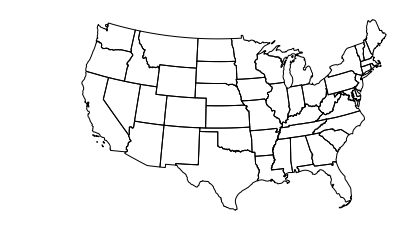

In [11]:
cdf.to_crs(epsg=proj_crs_US).plot( edgecolor='k', facecolor=(1, 1, 1, 0))
ax = plt.gca()
ax.set_axis_off()
xlim, ylim = ax.get_xlim(), ax.get_ylim()

In [12]:
# xlim, ylim defined so I can only show continental US 
rebox = lambda ax: ax.set(xlim=xlim, ylim=ylim)

Shapefiles for rivers, lakes downloaded from http://www.naturalearthdata.com/downloads/50m-physical-vectors/

In [13]:
riv = gpd.read_file(os.path.join('../input','ne_50m_rivers_lake_centerlines','ne_50m_rivers_lake_centerlines.shp'))
# remove missing geometry!
riv = riv[~riv.geometry.isnull()] 
# Bug: for some reason Colorado has two segments in Antarctica! drop them
# for i in range(len(riv.iloc[155].geometry)): plt.plot(*riv.iloc[155].geometry[i].coords.xy)
riv.at[155, 'geometry']  = riv.iloc[155].geometry[2:]
# riv[riv['name']=='Colorado'].geometry.plot() # looks good!
# keep onlt US rivers
riv = riv.cx[cdf.total_bounds[0]:cdf.total_bounds[2], cdf.total_bounds[1]:cdf.total_bounds[3]]
print('Dataframe shape ',riv.shape)
riv.head()

Dataframe shape  (62, 33)


,scalerank,featurecla,name,note,min_zoom,name_alt,min_label,name_en,label,wikidataid,...,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,wdid_score,ne_id,geometry
4,6,Lake Centerline,Alabama,None,5.0,None,6.0,Alabama,Alabama,Q558643,...,Alabama,Rio Alabama,Алабама,None,None,Sông Alabama,阿拉巴馬河,4,1159114961,(LINESTRING (-86.52176754393696 33.03211843501...
13,6,Lake Centerline,Chattahoochee,None,5.0,None,6.0,Chattahoochee,Chattahoochee,Q1068297,...,Chattahoochee,Rio Chattahoochee,Чаттахучи,Chattahoocheefloden,None,None,查特胡奇河,4,1159114925,(LINESTRING (-84.96633277034107 30.92263479236...
15,5,Lake Centerline,Colorado,None,4.7,None,5.7,Colorado,Colorado,Q1265,...,Kolorado,Colorado,Колорадо,Coloradofloden,Kolorado Nehri,Sông Colorado,科羅拉多河,4,1159112837,(LINESTRING (-114.3769148425459 34.53970083292...
16,3,Lake Centerline,Columbia,None,3.0,None,4.0,Columbia,Columbia,Q2251,...,Kolumbia,Rio Columbia,Колумбия,Columbiafloden,Kolumbiya Nehri,Sông Columbia,哥倫比亞河,4,1159124363,(LINESTRING (-118.0721673248621 48.66390330659...
32,5,Lake Centerline,Klamath,None,4.7,None,5.7,Klamath,Klamath,Q968640,...,None,Rio Klamath,Кламат,None,None,None,None,4,1159113143,LINESTRING (-121.9212088691939 42.475133775703...


These rivers are from all over the world! We only took the ones in the US. Take the bounding box of the Continental US dataframe, and keep only rivers that are inside of the region by using `.cx[minx:maxx, miny,maxy]` and where the bounding box is defined by `cdf.total_bounds`.

In [14]:
# make a geodataframe with the bounding box, just for fun
boxdf = gpd.GeoDataFrame(gpd.GeoSeries(box(*cdf.total_bounds)), columns=['geometry'], crs = {'init': 'epsg:{}'.format(proj_crs_latlon)})

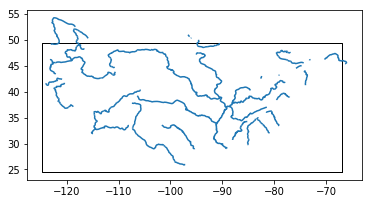

In [15]:
riv.plot()
boxdf.plot(ax=plt.gca(), facecolor=(1,1,1,0), edgecolor='k');
# plt.gca().set(xlim=(cdf.total_bounds[0],cdf.total_bounds[2]), ylim=(cdf.total_bounds[1],cdf.total_bounds[3]));

In [16]:
lak = gpd.read_file(os.path.join('../input','ne_50m_lakes','ne_50m_lakes.shp'))
# remove missing geometry!
lak = lak[~lak.geometry.isnull()] 
# keep only US lakes
lak = lak.cx[cdf.total_bounds[0]:cdf.total_bounds[2], cdf.total_bounds[1]:cdf.total_bounds[3]]
print('Dataframe shape ',lak.shape)
lak.head()

Dataframe shape  (51, 36)


,scalerank,featurecla,name,name_alt,note,admin,namepar,min_zoom,min_label,name_abb,...,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,wdid_score,ne_id,geometry
4,0,Lake,Lake Erie,Lakes,None,admin-0,None,1.0,3.0,L. Erie,...,Erie,Lago Erie,Эри,Eriesjön,Erie Gölü,Hồ Erie,伊利湖,4,1159106757,"POLYGON ((-83.10483398437499 42.28642578125, -..."
11,0,Lake,Lake Ontario,None,None,admin-0,None,1.0,3.0,L. Ontario,...,Ontario,Lago Ontário,Онтарио,Ontariosjön,Ontario Gölü,Hồ Ontario,安大略湖,4,1159106765,"POLYGON ((-75.786572265625 44.484326171875, -7..."
13,0,Lake,Lake Saint Clair,None,None,admin-0,None,1.0,3.0,L. St. Clair,...,None,Lago Saint Clair,Сент-Клэр,Lake St. Clair,None,None,聖克萊爾湖,5,1159106775,"POLYGON ((-83.07646484374999 42.27548828125, -..."
15,1,Lake,Lake Okeechobee,None,None,None,None,1.7,3.6,L. Okeechobee,...,Okeechobee,Lago Okeechobee,Окичоби,Lake Okeechobee,Okeechobee Gölü,None,奧基喬比湖,4,1159106781,"POLYGON ((-80.62875976562499 26.887060546875, ..."
21,1,Alkaline Lake,Great Salt Lake,None,None,None,None,1.7,3.6,Great Salt L.,...,Wielkie Jezioro Słone,Grande Lago Salgado,Большое Солёное озеро,Stora Saltsjön,Büyük Tuz Gölü,Hồ Muối Lớn,大盐湖,4,1159126421,"POLYGON ((-111.973876953125 41.0021484375, -11..."


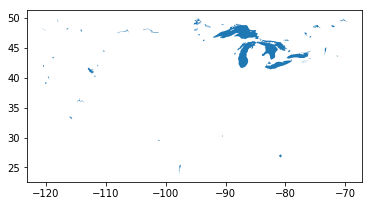

In [17]:
lak.plot();

### project dataframes

So far dataframe geometries are in latitude-longitude coordinates. The `to_crs` method works for projecting to a different reference system, but it is faster to do that once and redefine the geometries instead of repeating every time we make a plot

In [18]:
riv = riv.to_crs(epsg=proj_crs_US)
lak = lak.to_crs(epsg=proj_crs_US)
cdf = cdf.to_crs(epsg=proj_crs_US)


# Download drought monitor datasets

We have weekly shapefiles from 2000 onward at https://droughtmonitor.unl.edu/data/shapefiles_m/. Need to download them: we will use `requests` and `BeautifulSoup` to parse the simple Apache HTML listing. The parsing to is simple: we take all `USDM_YYYYMMDD_M.zip` files, so we pick the ones starting with USDM/usdm (somebody chnged it from uppercase to lowercase in May 2018...) and skip the `USDM_current` file.

**NB**: as of December 1 2018, this is 987 files, each about 1-2MB, so this is at least about 1GB of zipped data, 2GB unzipped. Make sure you have the available space, and go get a coffee while everything downloads.

In [102]:
url_base = 'https://droughtmonitor.unl.edu/data/shapefiles_m/'
page = requests.get(url_base).text

soup = BeautifulSoup(page, 'html.parser')
all_files = [linkarg for node in soup.find_all('a') for linkarg in [node.contents[0]] if 
             (linkarg.endswith('.zip') and linkarg.startswith(('USDM','usdm')) and 'current' not in node.contents[0])]
all_links = [ url_base+f for f in all_files ]
all_dates = [ '-'.join([ss[:4],ss[4:6],ss[6:]]) for f in all_files for ss in [f.split('_')[1]] ]

print('Number of shapefiles:',len(all_files))
print(all_files[:5])
print(all_dates[:5], all_dates[-5:])

Number of shapefiles: 987
[u'USDM_20000104_M.zip', u'USDM_20000111_M.zip', u'USDM_20000118_M.zip', u'USDM_20000125_M.zip', u'USDM_20000201_M.zip']
[u'2000-01-04', u'2000-01-11', u'2000-01-18', u'2000-01-25', u'2000-02-01'] [u'2018-10-30', u'2018-11-06', u'2018-11-13', u'2018-11-20', u'2018-11-27']


If files are not already in the input directory, this will take a while to download them all...

In [21]:
all_shapefiles = []
for link in all_links:
    all_shapefiles.append(shapefile_check_or_download(link))

In [22]:
len(all_shapefiles), all_shapefiles[:5], all_shapefiles[-5:]

(987,
 [u'input/USDM_20000104_M/USDM_20000104.shp',
  u'input/USDM_20000111_M/USDM_20000111.shp',
  u'input/USDM_20000118_M/USDM_20000118.shp',
  u'input/USDM_20000125_M/USDM_20000125.shp',
  u'input/USDM_20000201_M/USDM_20000201.shp'],
 [u'input/usdm_20181030_M/USDM_20181030.shp',
  u'input/usdm_20181106_M/USDM_20181106.shp',
  u'input/usdm_20181113_M/USDM_20181113.shp',
  u'input/usdm_20181120_M/USDM_20181120.shp',
  u'input/usdm_20181127_M/USDM_20181127.shp'])

Now we want to load everything. Possible strategies:
- add them all to one dataframe, remembering that for each there are 5 shapefiles, and them act accordingly when plotting
- make a separate dataframe for each drought category, and distribute each input accordingly.
- if memory is a problem, one could load each file, add the shapefiles to the plot and then replace the file.

Note: the datasets are not all in the same nice format (one `MultiPolygon` for each drought classification). Some of them have multiple rows corresponding to each drough classification. Will need to use the `dissolve` method of GeoPandas (same as `groupby` in pandas, but doing union of geometry elements).

# Exploratory analysis

## test latest data

Load latest data from https://droughtmonitor.unl.edu/data/shapefiles_m/USDM_current_M.zip, the result of which should look similar to the map displayed at https://droughtmonitor.unl.edu/CurrentMap.aspx

In [23]:
filename = shapefile_check_or_download('https://droughtmonitor.unl.edu/data/shapefiles_m/USDM_current_M.zip')
print(filename)

input/USDM_current_M/USDM_20181127.shp


In [25]:
df = gpd.read_file(filename)
df.head()

,OBJECTID,DM,Shape_Leng,Shape_Area,geometry
0,1,0,4.147547e+07,9.245710e+11,(POLYGON ((-66.78357696666427 17.9801044426057...
1,2,1,2.702096e+07,8.958565e+11,(POLYGON ((-80.03907012981871 26.5528430910080...
2,3,2,2.475946e+07,5.875896e+11,(POLYGON ((-104.9893650333722 32.1834441458512...
3,4,3,8.494839e+06,2.303452e+11,(POLYGON ((-115.0561683481062 32.7798253011737...
4,5,4,1.792391e+06,1.028067e+11,(POLYGON ((-105.3809187533277 37.5294086480186...


In [26]:
df = df.to_crs(epsg=proj_crs_US)
# df1 = df.cx[cdf.total_bounds[0]:cdf.total_bounds[2],:].cx[:, cdf.total_bounds[1]:cdf.total_bounds[3]]

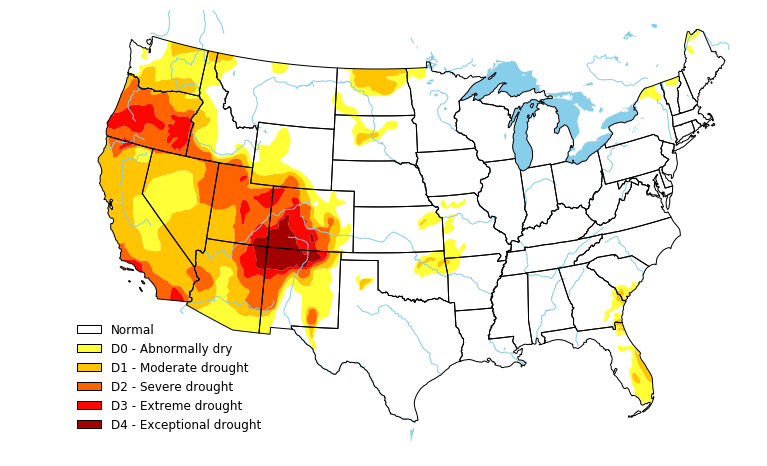

In [37]:
fig = plt.figure(figsize=(10,6))
ax = plt.Axes(fig, [0., 0., 1., 1.]) 
fig.add_axes(ax)
ax.set_axis_off()

riv.plot(ax=ax, color='skyblue', lw=1)
lak.plot(ax=ax, facecolor='skyblue', lw=1)
cdf.plot(ax=ax, edgecolor='k', facecolor=(1, 1, 1, 0), zorder=5)
for i in range(5):
    df.iloc[[i]].plot(ax=ax, color=cols[i])
rebox(ax)
plt.legend(handles=pp, loc = 'lower left', frameon=False, fontsize=12);

Fraction of US land that is in a given state of drought

[0.010926896655975637, 0.024482429706098225, 0.06245245543575426, 0.09521686104696371, 0.0982688014916732]


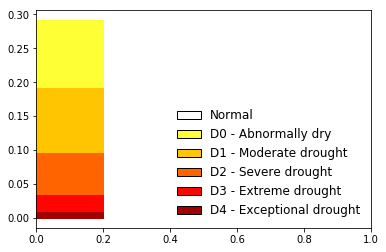

In [39]:
ratios = (df.Shape_Area / us_area).tolist()[::-1]
print(ratios)
for i in range(5):
    t = sum(ratios[:i+1]) if i<5 else sum(ratios)
    b = sum(ratios[:i])
    plt.fill_between((0,0.2),(t,t), (b,b), color=cols[::-1][i])
plt.legend(handles=pp, loc = 'lower right', frameon=False, fontsize=12);
plt.xlim(0,1);

## test historic data

Not all datasets are in the same nice format (one row per DM condition). Some have multiple rows with the same DM specification, which we will need to merge to have a clean dataset.

In [29]:
f = gpd.read_file(all_shapefiles[1])[['DM','Shape_Area','geometry']]
f

,DM,Shape_Area,geometry
0,0,2.872050e+12,(POLYGON ((-97.21749848261915 26.0096822453174...
1,1,7.421225e+11,(POLYGON ((-97.18679785021764 27.8190240569945...
2,1,9.626607e+09,(POLYGON ((-155.7921134795219 20.2541462071172...
3,1,4.287946e+11,POLYGON ((-87.90322502474545 43.02641973497227...
4,2,1.110521e+11,POLYGON ((-81.69679606956379 30.42141957815699...
5,2,4.537532e+11,(POLYGON ((-95.82703344059276 28.6573478639905...
6,2,4.697640e+10,POLYGON ((-86.26203098563548 39.49464483812682...
7,2,1.592360e+11,"POLYGON ((-98.7900016111201 40.06763938435755,..."


In [30]:
f1 = f.dissolve(by='DM',aggfunc='sum').reset_index(drop=True)
f1

,geometry,Shape_Area
0,(POLYGON ((-97.28329441369965 26.5308482022546...,2.872050e+12
1,(POLYGON ((-155.7921134795219 20.2541462071172...,1.180544e+12
2,(POLYGON ((-81.69679606956379 30.4214195781569...,7.710177e+11


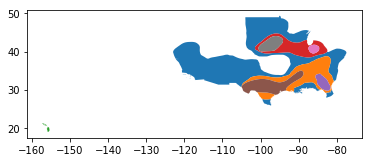

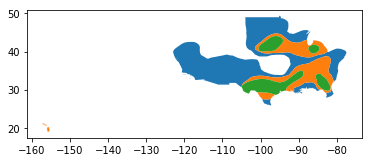

In [31]:
for i in range(len(f)):
    f.iloc[[i]].plot(ax=plt.gca(), color=plt.get_cmap('tab10')(i))
plt.figure()
for i in range(len(f1)):
    f1.iloc[[i]].plot(ax=plt.gca(), color=plt.get_cmap('tab10')(i))

See how the first dataset has disjoint polygons? This is now fixed in the second case.

In [32]:
load_files_into_dataframes(all_shapefiles[14:15], all_dates[14:15])

 1/1 --- input/USDM_20000411_M/USDM_20000411.shp


[        date                                           geometry    Shape_Area
 0 2000-04-11  (POLYGON ((1744509.301977857 -2086111.94281075...  1.459238e+12,
         date                                           geometry    Shape_Area
 0 2000-04-11  (POLYGON ((277242.5414852309 -2052996.63111555...  1.003060e+12,
         date                                           geometry    Shape_Area
 0 2000-04-11  (POLYGON ((281869.8642535779 -2097537.96668921...  1.065808e+12,
 Empty GeoDataFrame
 Columns: [date, geometry, Shape_Area]
 Index: [],
 Empty GeoDataFrame
 Columns: [date, geometry, Shape_Area]
 Index: []]

Load a sample of shapefiles, carefully chosen to have different number of drought categories (first two sets have 0,1,2, while last two have 0,1,2,3). The constructed dataframes will have missing rows for dates in which the drought did not reach high levels. For example here the D3 dataframe has only two entries (but note that the row indices are as one would expect) while the D4 has zero entries (no exceptional drought in this period).

In [33]:
all_dfs = load_files_into_dataframes(all_shapefiles[14:18], all_dates[14:18])

 4/4 --- input/USDM_20000502_M/USDM_20000502.shp


In [34]:
all_dfs

[        date                                           geometry    Shape_Area
 0 2000-04-11  (POLYGON ((1744509.301977857 -2086111.94281075...  1.459238e+12
 1 2000-04-18  (POLYGON ((3603642.208448558 -2240659.59199968...  1.586167e+12
 2 2000-04-25  (POLYGON ((3620518.40570103 -2238122.113381292...  1.527249e+12
 3 2000-05-02  (POLYGON ((3625280.570747379 -2243183.58201326...  1.473838e+12,
         date                                           geometry    Shape_Area
 0 2000-04-11  (POLYGON ((277242.5414852309 -2052996.63111555...  1.003060e+12
 1 2000-04-18  (POLYGON ((262560.1860302977 -1958391.84988326...  9.470061e+11
 2 2000-04-25  (POLYGON ((262560.1860342188 -1958391.84998288...  8.862479e+11
 3 2000-05-02  (POLYGON ((264072.6980475995 -2012662.36685622...  9.828099e+11,
         date                                           geometry    Shape_Area
 0 2000-04-11  (POLYGON ((281869.8642535779 -2097537.96668921...  1.065808e+12
 1 2000-04-18  (POLYGON ((281869.8641533767 -20975

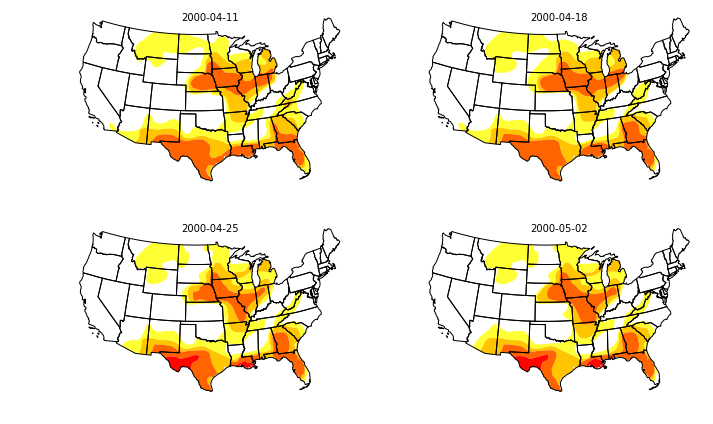

In [36]:
fig, axes = plt.subplots(2,2,figsize=(10,6))
fig.tight_layout()
for i in range(len(all_dfs[0])):
    ax = axes[i//2, i%2]
    cdf.plot(ax=ax, edgecolor='k', facecolor=(1, 1, 1, 0), zorder=5)
    ax.set_axis_off()
    for j in range(len(all_dfs)):
        try:
            all_dfs[j].loc[[i]].plot(ax=ax,color=cols[j])
        except: pass
    rebox(ax)
    ax.text(0.5,0.94, all_dfs[0].loc[i,'date'].strftime('%Y-%m-%d'), transform = ax.transAxes, ha='center')
fig.tight_layout()

Get areas of regions in different drought status. 

In [40]:
areas = pd.DataFrame([], columns = ['date','D0','D1','D2','D3','D4'])
for i in range(len(all_dfs[0])): # loop over dates
    aa = []
    for j in range(len(all_dfs)): # loop over drought categories, try/except to see if there is a datapoint
        try: a = all_dfs[j].loc[i,'Shape_Area']/us_area
        except: a=0.
        aa.append(a)
    areas.loc[i] = [all_dfs[0].loc[i,'date']]+aa
areas.head()

,date,D0,D1,D2,D3,D4
0,2000-04-11,0.155096,0.106611,0.113280,0.000000,0.0
1,2000-04-18,0.168587,0.100653,0.120877,0.000000,0.0
2,2000-04-25,0.162325,0.094196,0.095921,0.012242,0.0
3,2000-05-02,0.156648,0.104459,0.095732,0.013756,0.0


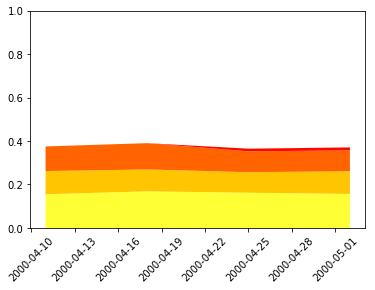

In [42]:
# areas.iloc[:,1:].plot.area(color=cols)
plt.stackplot(areas['date'].dt.to_pydatetime(), areas.iloc[:,1:].T, colors=cols)
# reverse stacking - more drought at bottom
# plt.stackplot(areas['date'].dt.to_pydatetime(), areas.iloc[:,:0:-1].T, colors=cols[::-1]);
plt.xticks(rotation=45, ha='center')
plt.ylim(0,1);

Alternatively, cumulative sum of region areas below a drought classification (e.g. D1+ $\to$ (D1,D0)), then use `fill_between`

In [43]:
areas = pd.DataFrame([], columns = ['date','D0+','D1+','D2+','D3+','D4+'])
for i in range(len(all_dfs[0])): # loop over dates
    aa = []
    a = 0
    for j in range(len(all_dfs))[::-1]: # loop over drought categories, from D4 to D0, add to total
        try: a += all_dfs[j].loc[i,'Shape_Area']/us_area
        except: pass
        aa.append(a)
    areas.loc[i] = [all_dfs[0].loc[i,'date']]+aa[::-1]
areas

,date,D0+,D1+,D2+,D3+,D4+
0,2000-04-11,0.374988,0.219891,0.113280,0,0
1,2000-04-18,0.390117,0.221530,0.120877,0,0
2,2000-04-25,0.364684,0.202359,0.108163,0.0122421,0
3,2000-05-02,0.370594,0.213946,0.109487,0.0137556,0


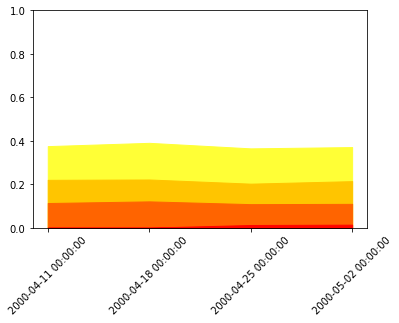

In [45]:
for i in range(5):
    plt.fill_between(range(len(areas)), areas[areas.columns[i+1]].astype(float), color=cols[i])
plt.xticks(range(len(areas)),areas['date'], rotation=45, ha='center')
plt.ylim(0,1);

# Production-level run

With the functions defined above, it is clear what we can do. First, we need to import all the shapefiles. This will take a while (the slow step is the `dissolve`)... about 20-30 minutes

In [46]:
%%time
all_dfs = load_files_into_dataframes(all_shapefiles, all_dates)

 987/987 --- input/usdm_20181127_M/USDM_20181127.shp
CPU times: user 24min 25s, sys: 20.6 s, total: 24min 46s
Wall time: 25min 32s


In [60]:
def drought_map(i, ax):
    """
    Draw drought map of the US, at index i of the DataFrame
    """
    ax.clear()
    ax.set_axis_off()
    riv.plot(ax=ax, color='skyblue', lw=1)
    lak.plot(ax=ax, facecolor='skyblue', lw=1)
    cdf.plot(ax=ax, edgecolor='k', facecolor=(1, 1, 1, 0), zorder=5)
    for j in range(5): # loop over drought categories
        try:
            all_dfs[j].loc[[i]].plot(ax=ax,color=cols)
        except: pass
    rebox(ax)
    ax.text(0.5,0.94, all_dfs[0].loc[i,'date'].strftime('%Y-%m-%d'), transform = ax.transAxes, ha='center', fontsize=14)
    ax.legend(handles=pp, loc = 'lower left', frameon=False, fontsize=11)

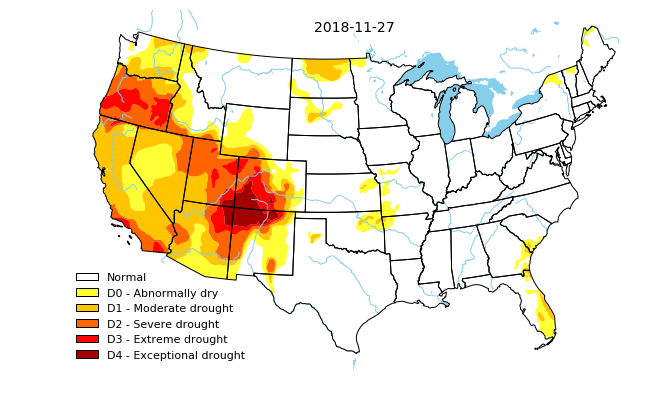

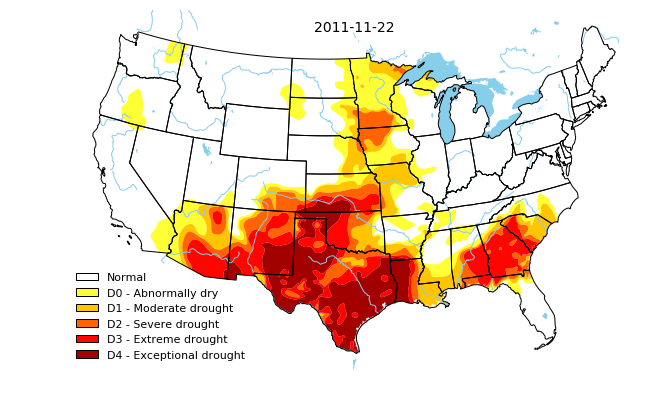

In [101]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0., 0., 1., 1])
drought_map(len(all_dfs[0])-1,ax);
fig.savefig('US_drought_20181127.png', dpi=200)

fig = plt.figure(figsize=(8,5))
ax = fig.add_axes([0., 0., 1., 1])
drought_map(620,ax);

In [51]:
areas = pd.DataFrame([], columns = ['date','D0','D1','D2','D3','D4'])
for i in range(len(all_dfs[0])): # loop over dates
    areas_vec = []
    for j in range(len(all_dfs)): # loop over drought categories, try/except to see if there is a datapoint
        try: a = all_dfs[j].loc[i,'Shape_Area']/us_area
        except: a=0.
        areas_vec.append(a)
    areas.loc[i] = [all_dfs[0].loc[i,'date']]+areas_vec
areas.head()

,date,D0,D1,D2,D3,D4
0,2000-01-04,0.228933,0.116116,0.078246,0.0,0.0
1,2000-01-11,0.305258,0.125475,0.081948,0.0,0.0
2,2000-01-18,0.346832,0.129549,0.085964,0.0,0.0
3,2000-01-25,0.362465,0.128245,0.083745,0.0,0.0
4,2000-02-01,0.298360,0.156188,0.084579,0.0,0.0


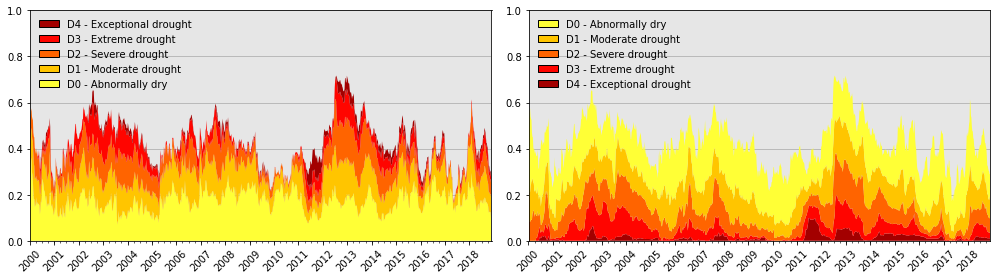

In [92]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,4))
d = areas['date'].dt.to_pydatetime()
ax1.stackplot(d, areas.iloc[:,1:].T, colors=cols)
ax2.stackplot(d, areas.iloc[:,:0:-1].T, colors=cols[::-1]);
for ax in (ax1, ax2):
    ax.set_axisbelow(True)
    ax.grid(True, axis='y')
    ax.xaxis.set_major_locator(mpl.dates.YearLocator())
    ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonth=range(1,13,3)))
    plt.setp(ax.get_xticklabels(),rotation=45,ha='center')
    ax.set(xlim=(d[0],d[-1]), ylim=(0,1), facecolor='0.9');
ax1.legend(handles=pp[:0:-1], loc = 'upper left', frameon=False, fontsize=10)
ax2.legend(handles=pp[1:], loc = 'upper left', frameon=False, fontsize=10)
fig.tight_layout()
fig.savefig('US_drought_timeseries.png')

In [118]:
def drought_series(i,ax):
    ax.clear()
    ax.set_axisbelow(True)
    ax.grid(True, axis='y')
    d = areas['date'].dt.to_pydatetime()
    ax.plot((d[i],d[i]),(0,1), c='0.4', lw=1)
    if i==0: i=1
    ax.stackplot(d[:i], areas.iloc[:i,1:].T, colors=cols)

    ax.xaxis.set_major_locator(mpl.dates.YearLocator())
    ax.xaxis.set_minor_locator(mpl.dates.MonthLocator(bymonth=range(1,13,3)))
    plt.setp(ax.get_xticklabels(),rotation=45,ha='center')
    ax.set(xlim=(d[0],d[-1]), ylim=(0,1), facecolor='0.9', ylabel='% in drought');

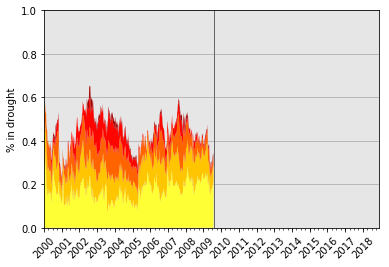

In [119]:
drought_series(500,plt.gca())

In [120]:
def animate(i, axes):
    drought_map(i,axes[0])
    drought_series(i,axes[1])
    axes[1].set(yticks=[0,0.25,0.5,0.75,1], yticklabels=[])
    axes[1].tick_params('y', length=0)

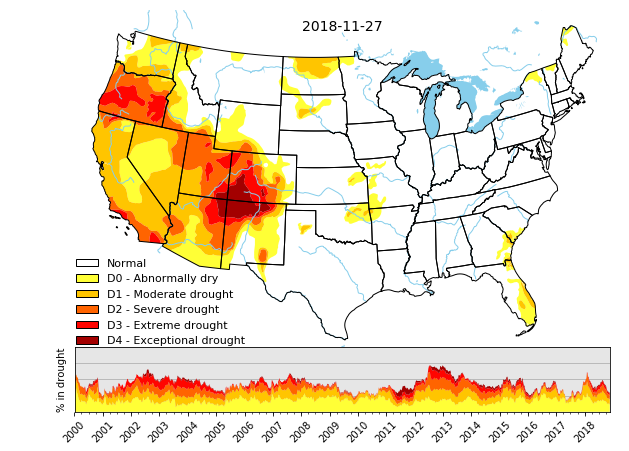

In [137]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_axes([0., 0.2, 1., 0.8])
ax2 = fig.add_axes([0.035, 0.07, 0.93, 0.15])
animate(len(all_shapefiles)-1, [ax1, ax2])
fig.savefig('US_drought_20181127_timeseries.png')

In [131]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')
rc('animation', embed_limit=200.)
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_axes([0., 0.2, 1., 0.8])
ax2 = fig.add_axes([0.035, 0.07, 0.93, 0.15])

frames=range(500,540)
anim = animation.FuncAnimation(fig, animate, frames=frames, fargs=([ax1,ax2],), interval=12);
plt.close(); 

In [133]:
%%time
HTML(anim.to_jshtml());

Complete animation saved to MP4 file. What should the *fps* be? There are 1k weekly data points for 19 years: I will pick `26 fps`, so that each year takes 2 seconds (52 weeks per year) and the video lasts for 40 seconds.

Note: it takes about 15 minutes to save the animation.

In [126]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_axes([0., 0.2, 1., 0.8])
ax2 = fig.add_axes([0.035, 0.07, 0.93, 0.15])

frames=range(len(all_shapefiles))
anim = animation.FuncAnimation(fig, animate, frames=frames, fargs=([ax1,ax2],), interval=12);
plt.close();

In [127]:
%%time
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'
anim.save('US_drought_animation.mp4', writer = animation.FFMpegWriter(fps=26))

CPU times: user 15min 34s, sys: 19.4 s, total: 15min 53s
Wall time: 16min 35s


<Figure size 432x288 with 0 Axes>

Make a GIF out of the MP4 file with FFMPEG. The second line creates a high-quality GIF with its own color palette, while the first is a low-quality GIF.

In [116]:
# ! /usr/local/bin/ffmpeg -y -loglevel quiet -i US_drought_animation.mp4 US_drought_animation.gif 
! /usr/local/bin/ffmpeg -y -loglevel quiet -i US_drought_animation.mp4 -filter_complex "[0:v] split [a][b];[a] palettegen [p];[b][p] paletteuse" US_drought_animation.gif
